# Evaluating Test Set

## Performance and Biases

### Random Forest Classifier

We will begin by evaluating the test set.

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       748
           1       0.93      0.91      0.92       713

    accuracy                           0.92      1461
   macro avg       0.92      0.92      0.92      1461
weighted avg       0.92      0.92      0.92      1461

Confusion Matrix


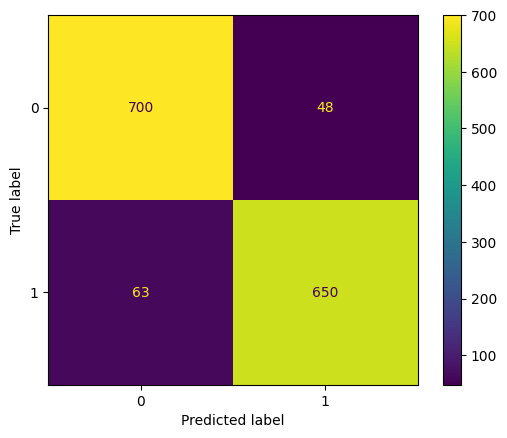

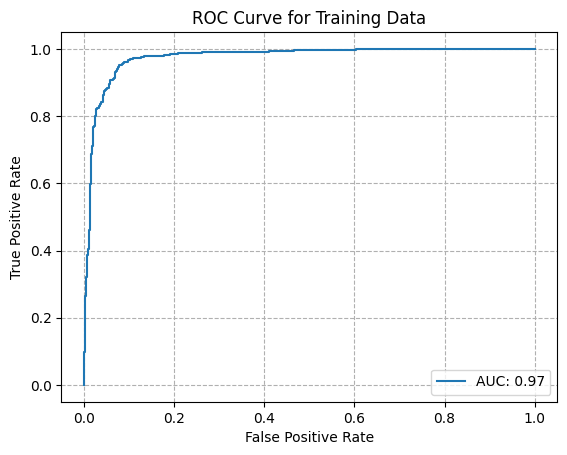

In [1]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib

# Load data
raw_KOI = pd.read_csv('KOI_cumulative.csv', comment='#')
data = pd.read_csv('transits.csv')
data = data.merge(raw_KOI.reset_index()[['kepoi_name', 'koi_disposition', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']], on='kepoi_name')

# Filter to only get time, flux, and the 3 contextual features
cols = data.columns
for col in cols:
    if (col.find('TIME') != -1 and col.find('CORR') == -1) or (col.find('PDCSAP_FLUX') != -1 and col.find('ERR') == -1) or (col.find('koi_disposition') != -1) or (col.find('koi_ror') != -1) or (col.find('koi_dikco_msky') != -1) or (col.find('koi_max_mult_ev') != -1) or (col.find('kepoi_name') != -1) or (col.find('kepid') != -1):
        pass
    else:
        data = data.drop(columns=col)

# Filter to not include candidate class
data = data[data['koi_disposition'] != 'CANDIDATE'].dropna()

# Engineer Features
n_times = 30
for i in range(n_times-1):
    change_time = (data[f'TIME{i+1}'] - data[f'TIME{i}'])
    change_flux = (data[f'PDCSAP_FLUX{i+1}'] - data[f'PDCSAP_FLUX{i}'])
    flux_over_time = change_flux / change_time
    data[f'FLUX_OVER_TIME{i}'] = flux_over_time

# Drop time and flux since it's no longer needed
for i in range(n_times):
    data = data.drop(columns=[f'TIME{i}', f'PDCSAP_FLUX{i}'])

# Split data into training and testing (80-20)
y = data['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=y)
y_train = data_train['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_train = data_train.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])
y_test = data_test['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_test = data_test.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])

# Show classification report
model = joblib.load('Models/random_forest.pkl')
y_pred = model.predict(X_test)
print('Classification Report')
print(classification_report(y_test, y_pred))

# Confusion Matrix
y_pred = model.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion)
print('Confusion Matrix')
disp.plot()
plt.show()

# Plot ROC curve
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.grid(linestyle='--')
plt.legend()
plt.show()

Now we can explore potential biases by looking at distributions for correct and incorrect predictions.

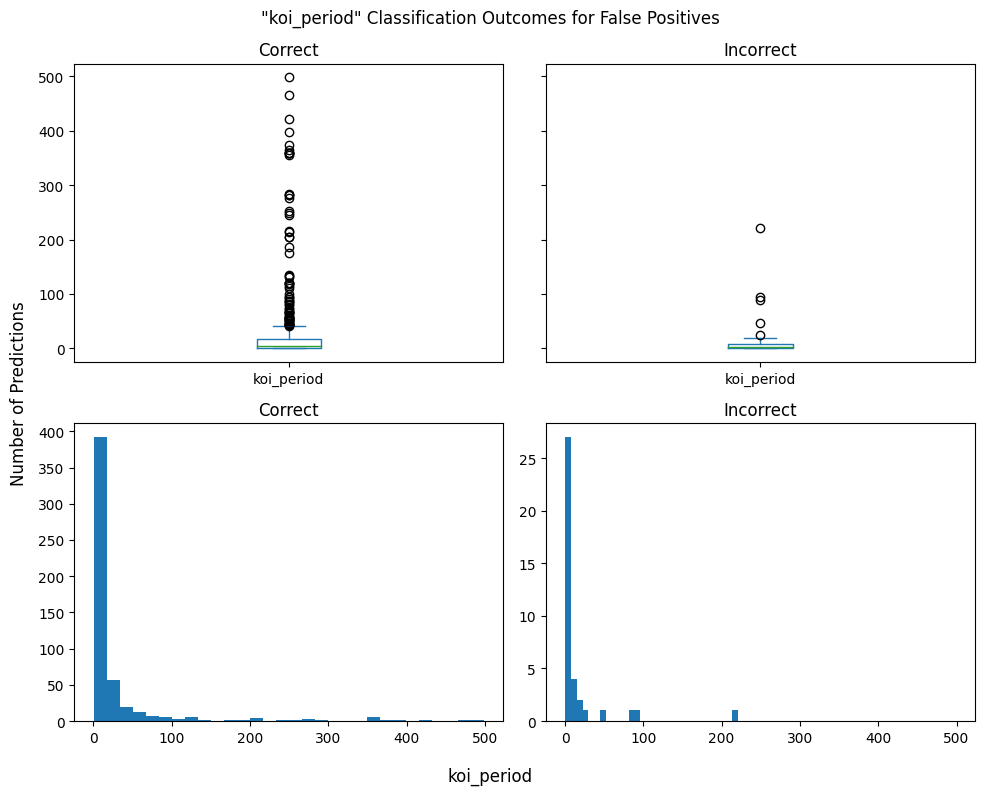

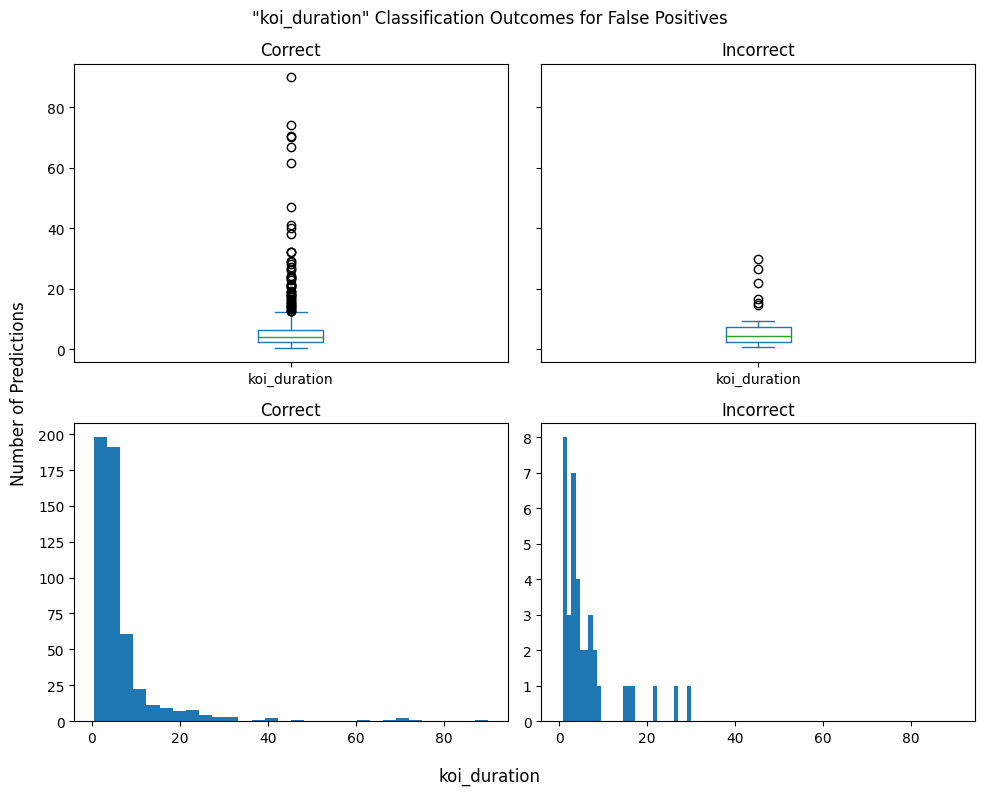

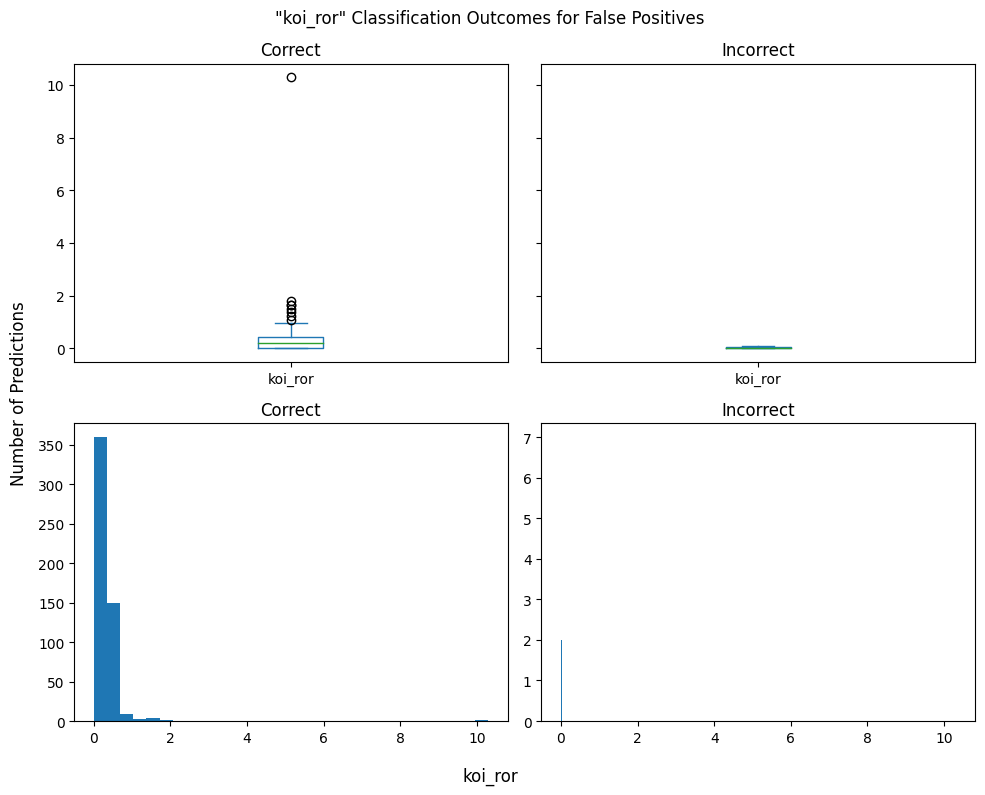

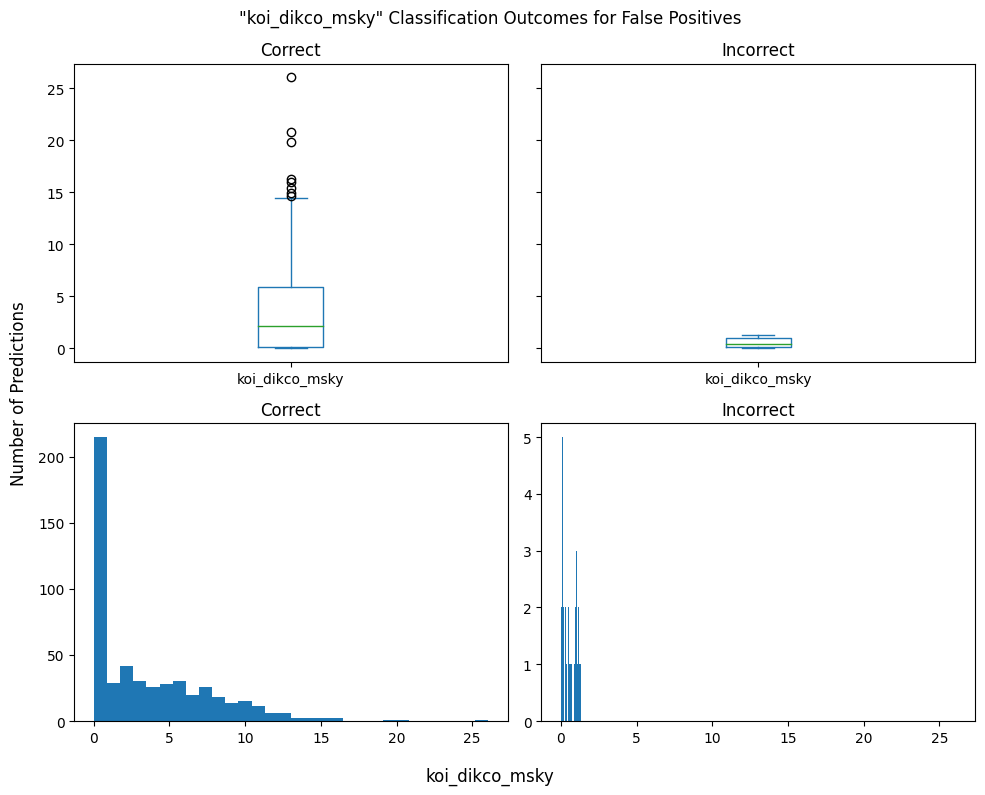

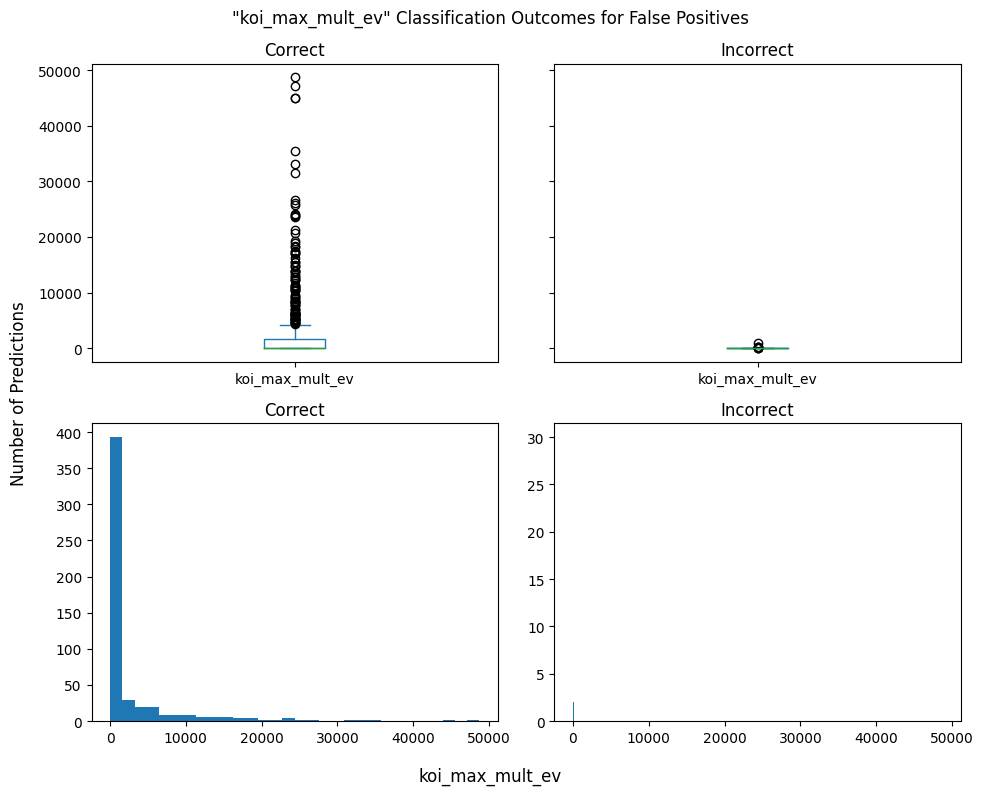

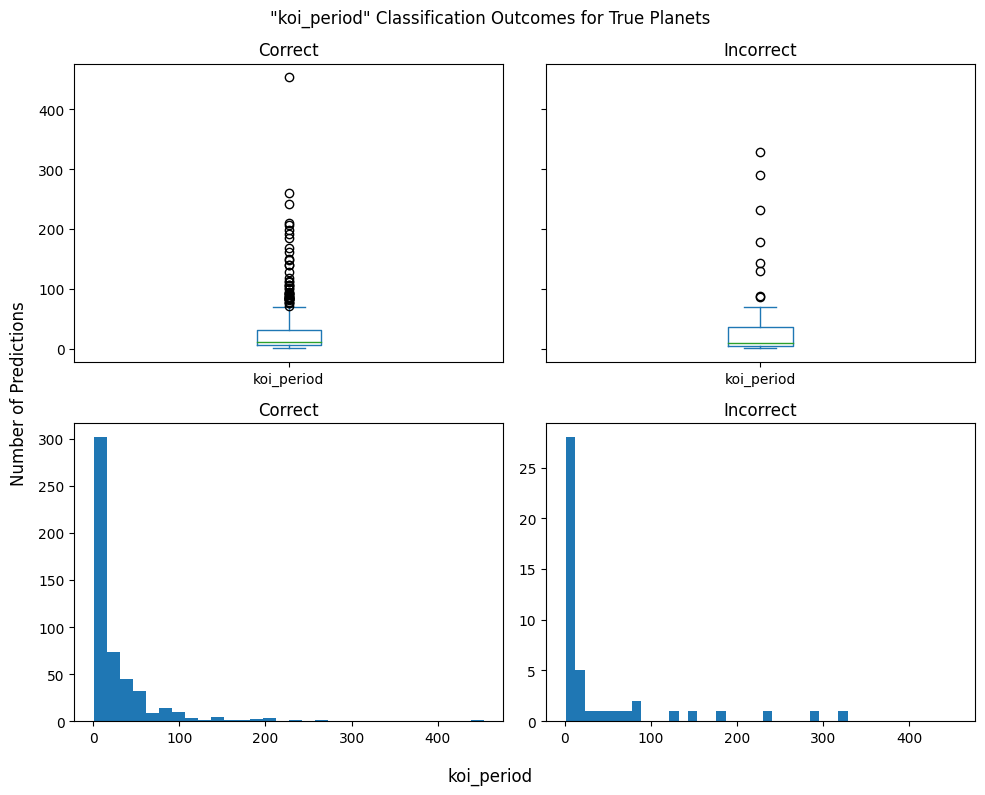

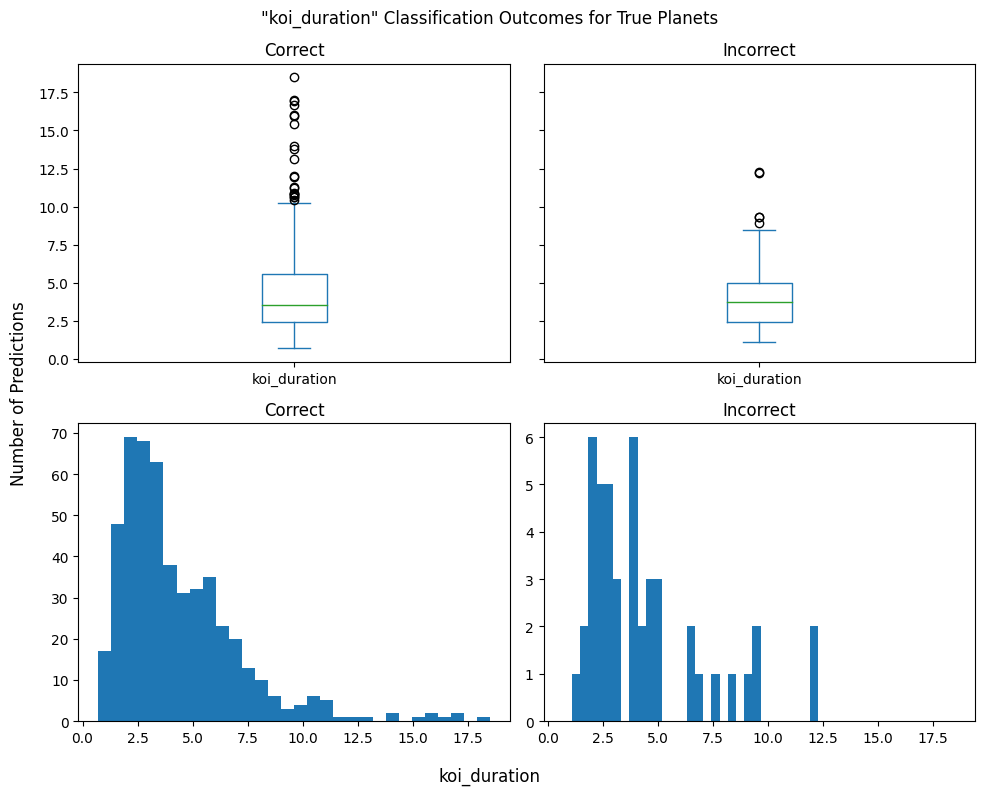

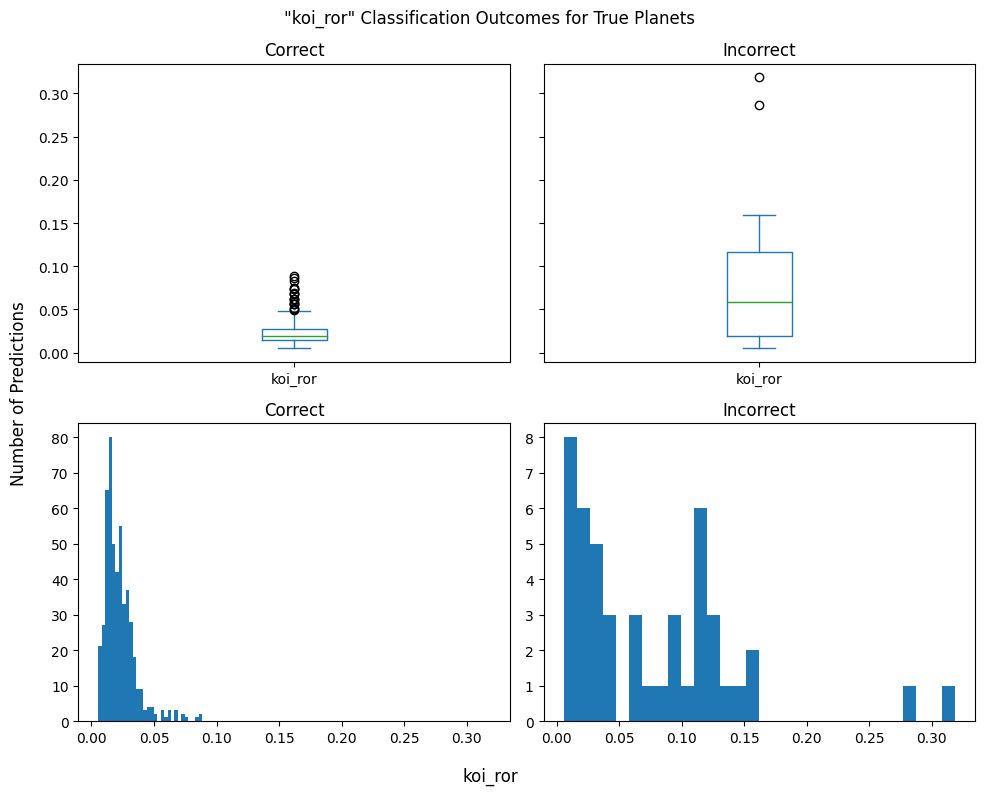

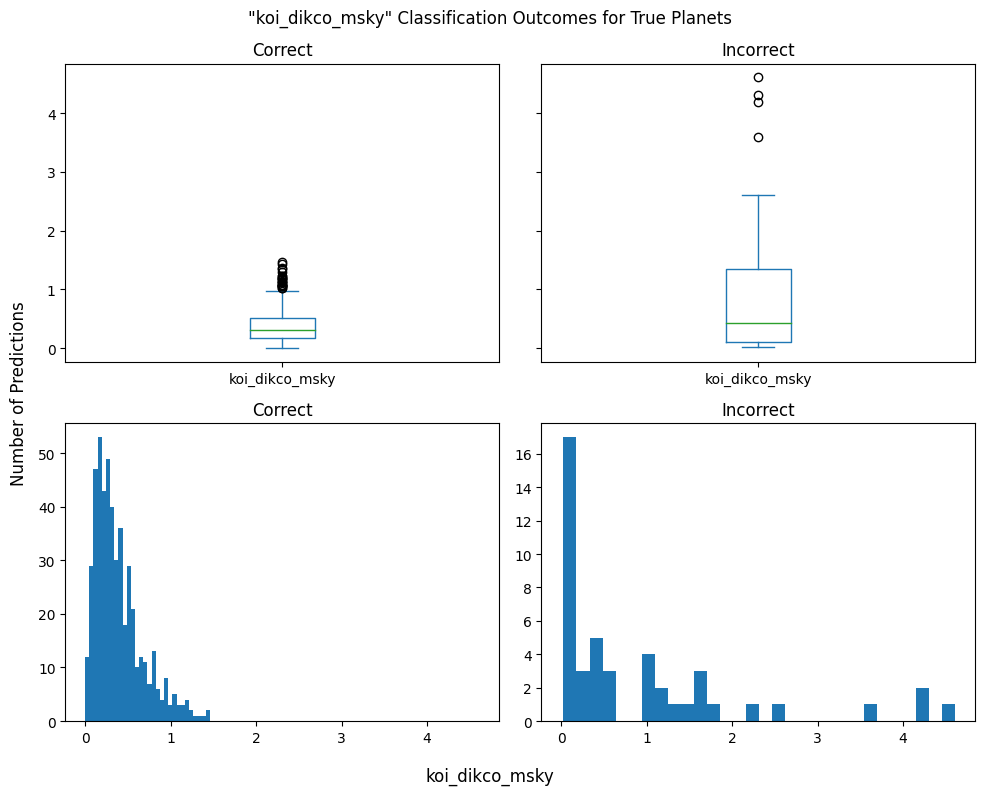

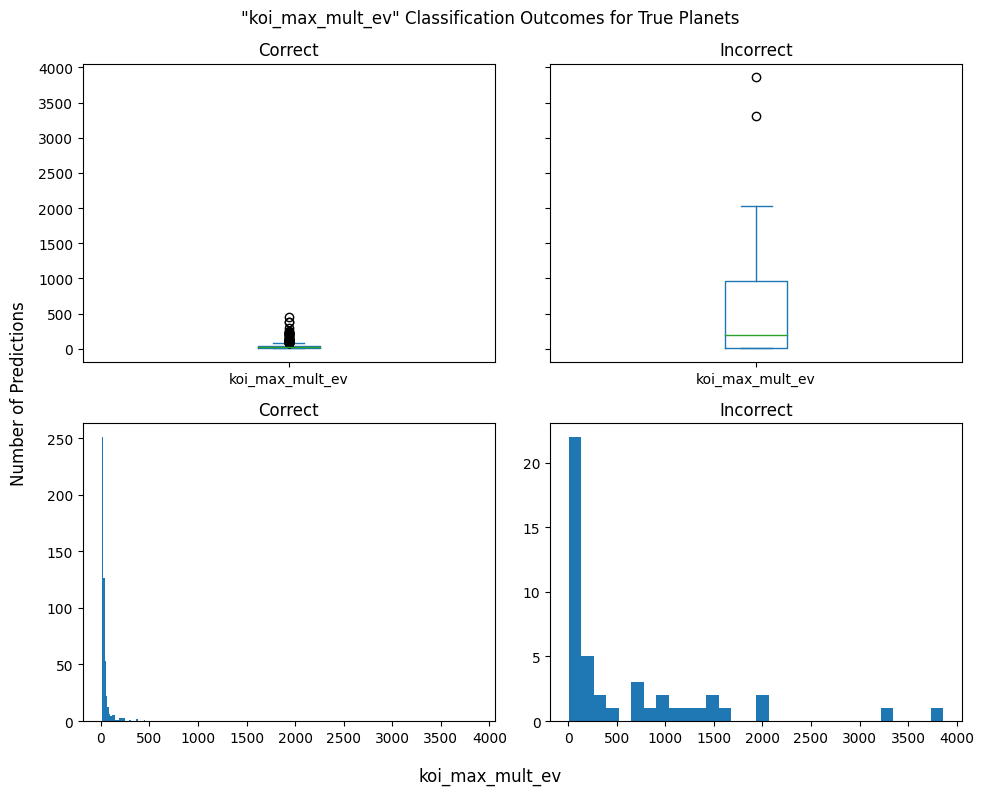

In [30]:
# Columns to explore
cols_to_explore = ['koi_period', 'koi_duration', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']

for class_index in [0, 1]:

    # Getting the data that made correct and incorrect predictions
    is_correct = ((y_test == y_pred) & (y_test == class_index))
    is_wrong = ((y_test != y_pred) & (y_test == class_index))
    correct_names = data_test[is_correct]['kepoi_name'].unique()
    wrong_names = data_test[is_wrong]['kepoi_name'].unique()
    correct_data = raw_KOI[raw_KOI['kepoi_name'].isin(correct_names)]
    wrong_data = raw_KOI[raw_KOI['kepoi_name'].isin(wrong_names)]

    # Plot
    for col in cols_to_explore:

        fig = plt.figure(figsize=(10, 8))

        # Set box plots
        ax1 = fig.add_subplot(2, 2, 1)
        correct_data[col].plot.box()
        ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)
        wrong_data[col].plot.box()
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        ax1.set_title('Correct')
        ax2.set_title('Incorrect')

        # Set histograms
        ax1 = fig.add_subplot(2, 2, 3)
        correct_data[col].plot.hist(bins=30)
        ax2 = fig.add_subplot(2, 2, 4, sharex=ax1)
        wrong_data[col].plot.hist(bins=30)
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        ax1.set_title('Correct')
        ax2.set_title('Incorrect')


        # Adjust labels and titles
        fig.supxlabel(f'{col}')
        fig.supylabel('Number of Predictions')
        if class_index == 1:
            fig.suptitle(f'"{col}" Classification Outcomes for True Planets')
        else:
            fig.suptitle(f'"{col}" Classification Outcomes for False Positives')
        plt.tight_layout()
        plt.show()

### Logistic Regression

We will make predictions on test set.

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       748
           1       0.88      0.96      0.92       713

    accuracy                           0.91      1461
   macro avg       0.92      0.91      0.91      1461
weighted avg       0.92      0.91      0.91      1461

Confusion Matrix


C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


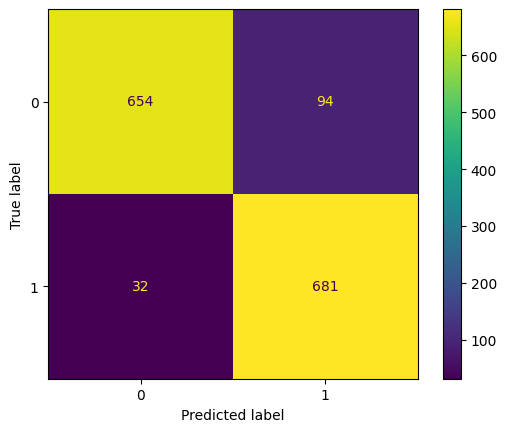

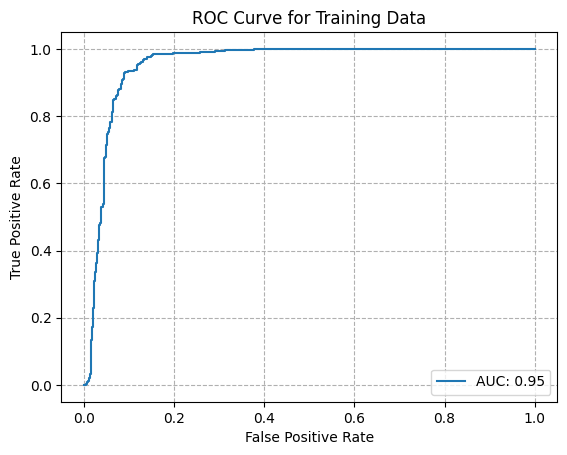

In [32]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Load data
raw_KOI = pd.read_csv('KOI_cumulative.csv', comment='#')
data = pd.read_csv('transits.csv')
data = data.merge(raw_KOI.reset_index()[['kepoi_name', 'koi_disposition', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']], on='kepoi_name')

# Filter to only get time, flux, and the 3 contextual features
cols = data.columns
for col in cols:
    if (col.find('TIME') != -1 and col.find('CORR') == -1) or (col.find('PDCSAP_FLUX') != -1 and col.find('ERR') == -1) or (col.find('koi_disposition') != -1) or (col.find('koi_ror') != -1) or (col.find('koi_dikco_msky') != -1) or (col.find('koi_max_mult_ev') != -1) or (col.find('kepoi_name') != -1) or (col.find('kepid') != -1):
        pass
    else:
        data = data.drop(columns=col)

# Filter to not include candidate class
data = data[data['koi_disposition'] != 'CANDIDATE'].dropna()

# Engineer Features
n_times = 30
for i in range(n_times-1):
    change_time = (data[f'TIME{i+1}'] - data[f'TIME{i}'])
    change_flux = (data[f'PDCSAP_FLUX{i+1}'] - data[f'PDCSAP_FLUX{i}'])
    flux_over_time = change_flux / change_time
    data[f'FLUX_OVER_TIME{i}'] = flux_over_time

# Drop time and flux since it's no longer needed
for i in range(n_times):
    data = data.drop(columns=[f'TIME{i}', f'PDCSAP_FLUX{i}'])

# Split data into training and testing (80-20)
y = data['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=y)
y_train = data_train['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_train = data_train.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])
y_test = data_test['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_test = data_test.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=scaler.get_feature_names_out())
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=scaler.get_feature_names_out())


# Show classification report
model = joblib.load('Models/logistic_regression.pkl')
y_pred = model.predict(X_test)
print('Classification Report')
print(classification_report(y_test, y_pred))

# Confusion Matrix
y_pred = model.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion)
print('Confusion Matrix')
disp.plot()
plt.show()

# Plot ROC curve
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.grid(linestyle='--')
plt.legend()
plt.show()

We will show distributions of the predictions.

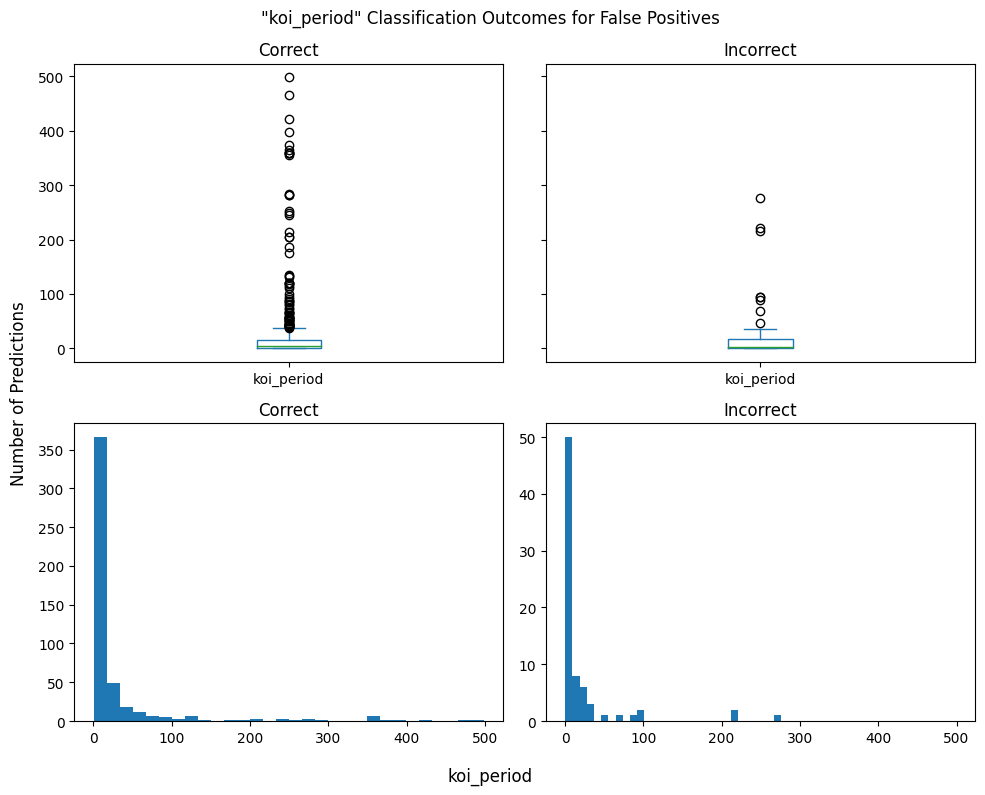

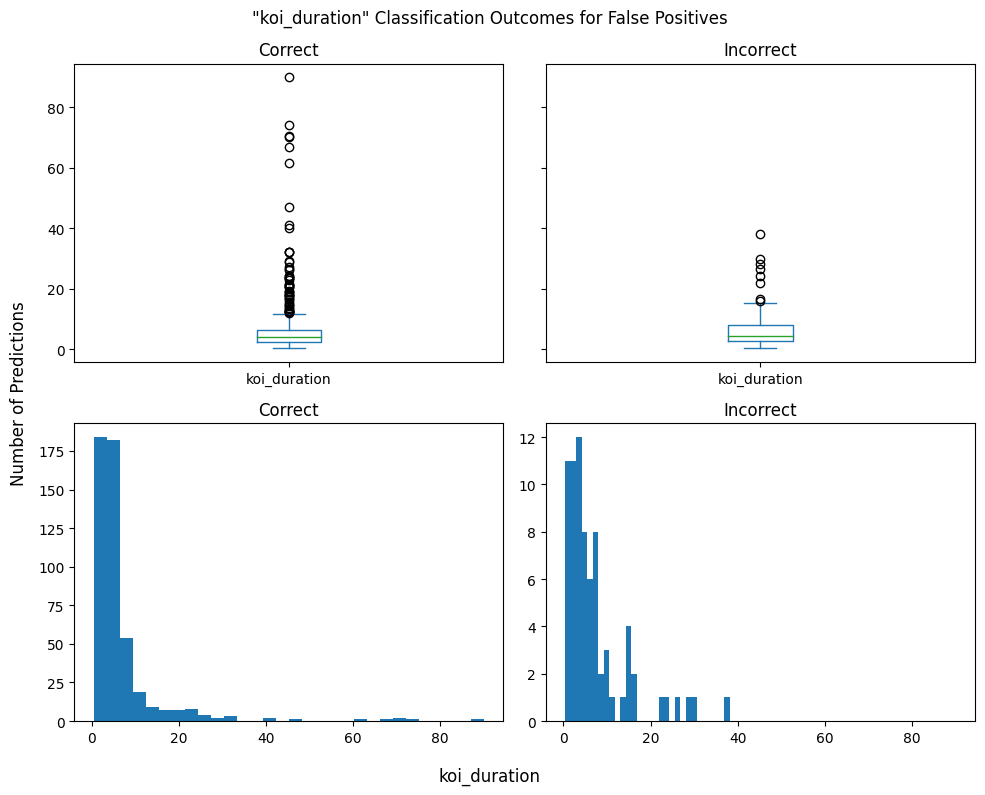

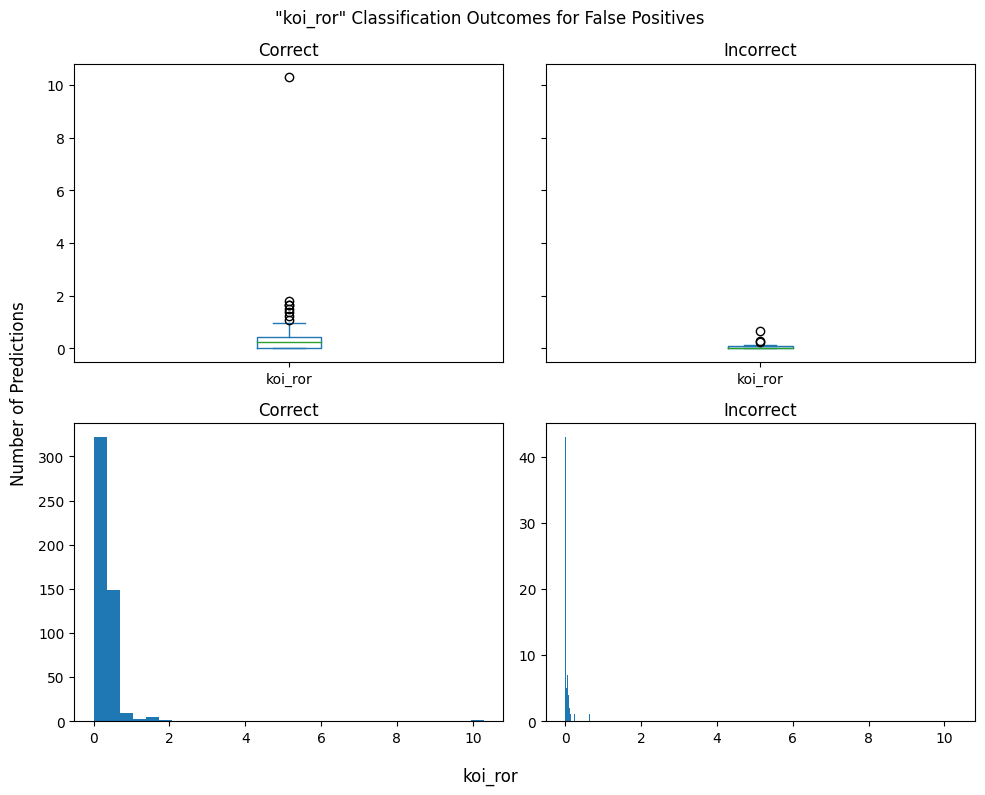

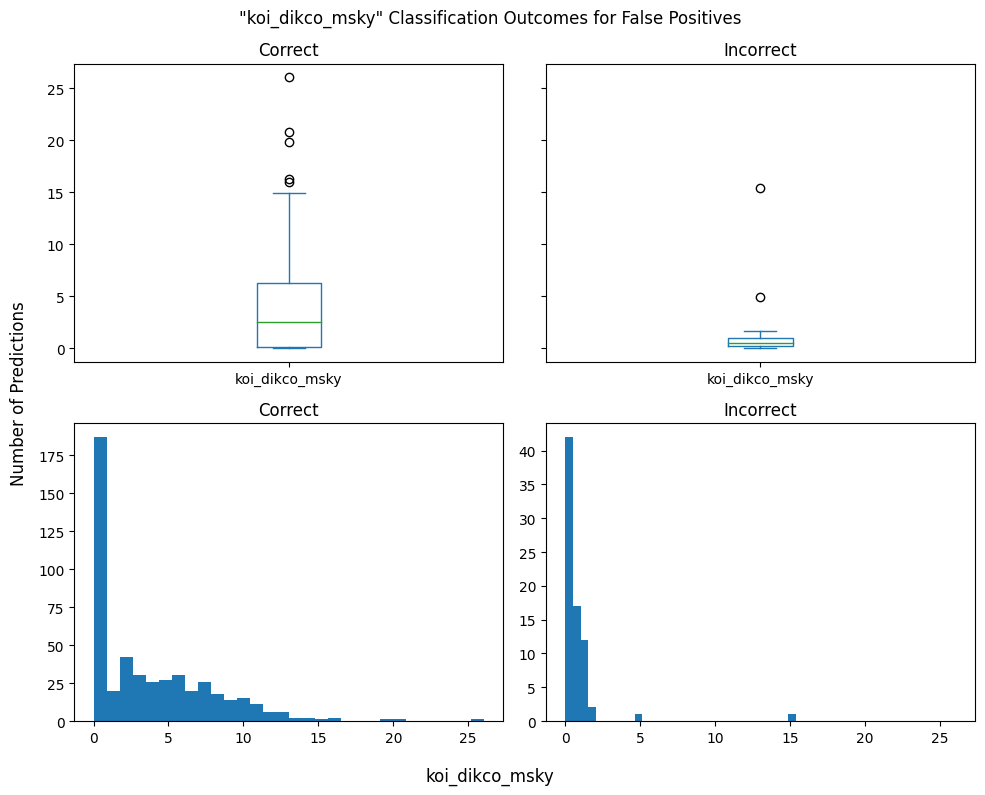

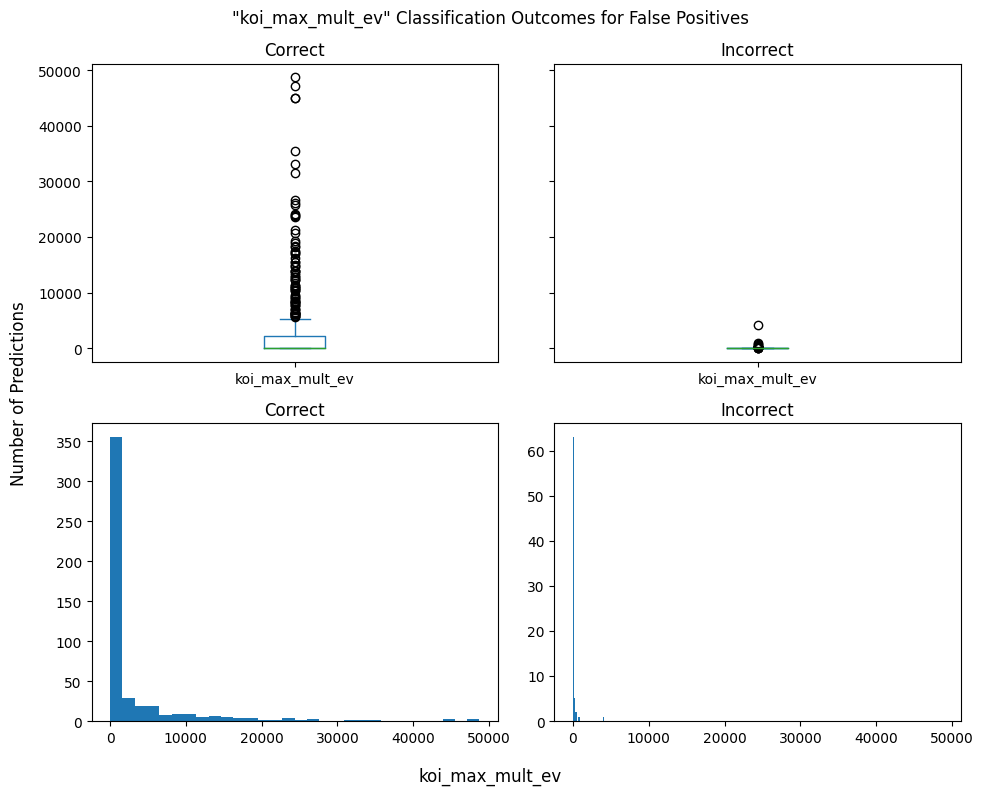

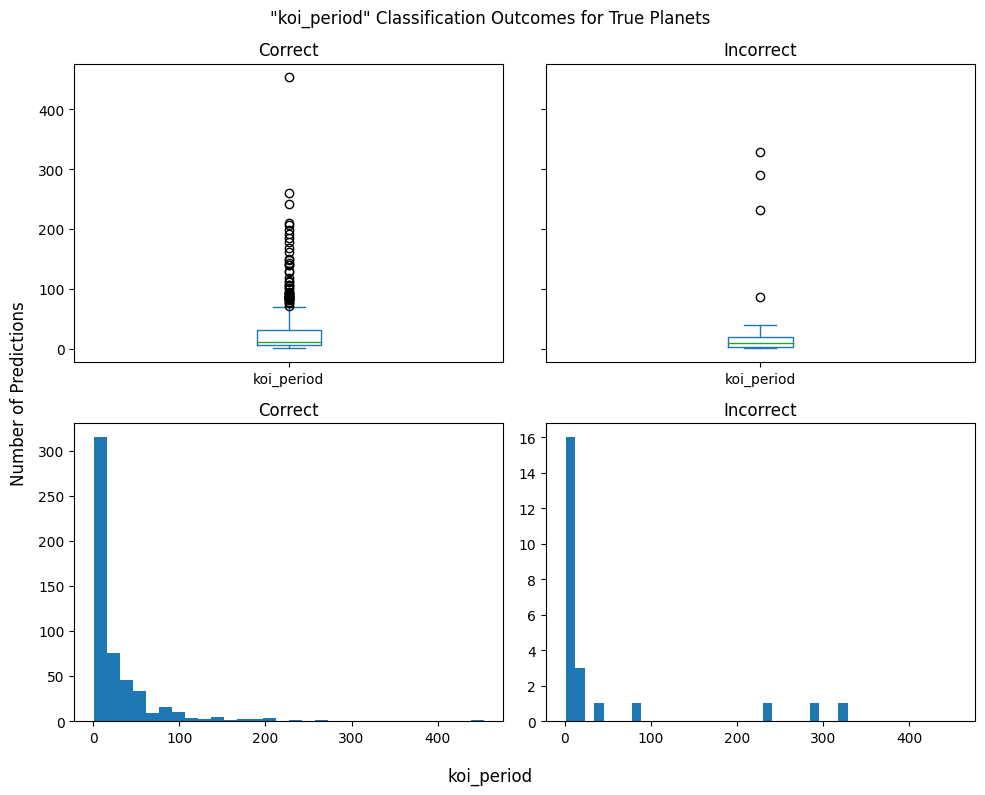

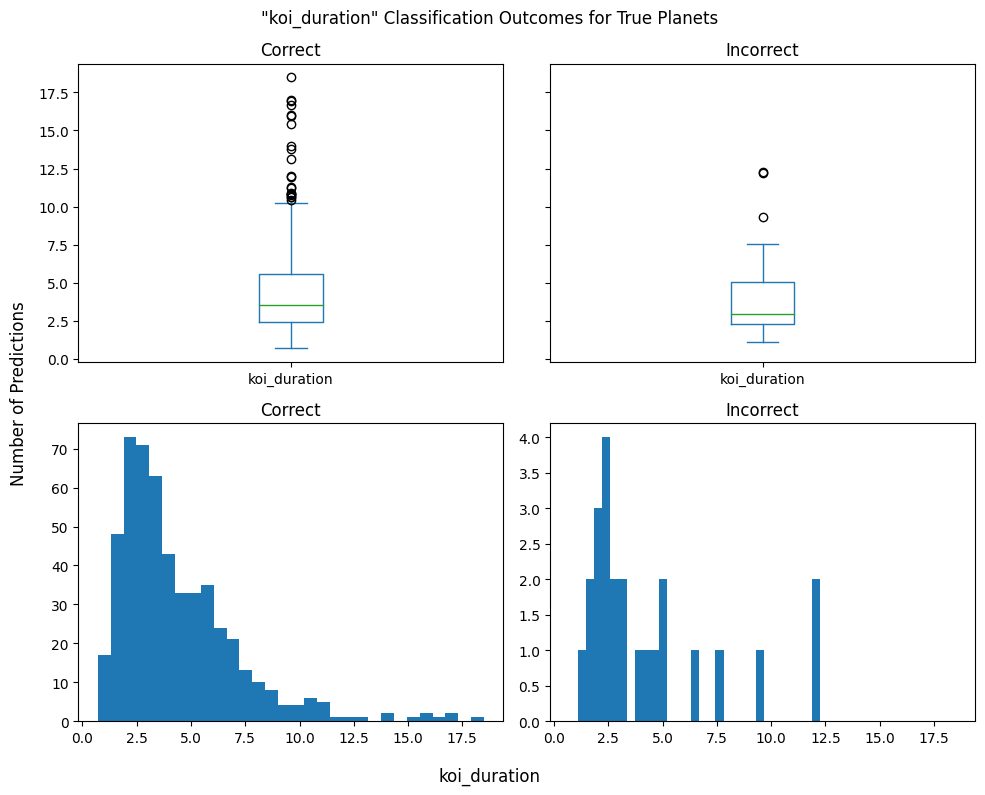

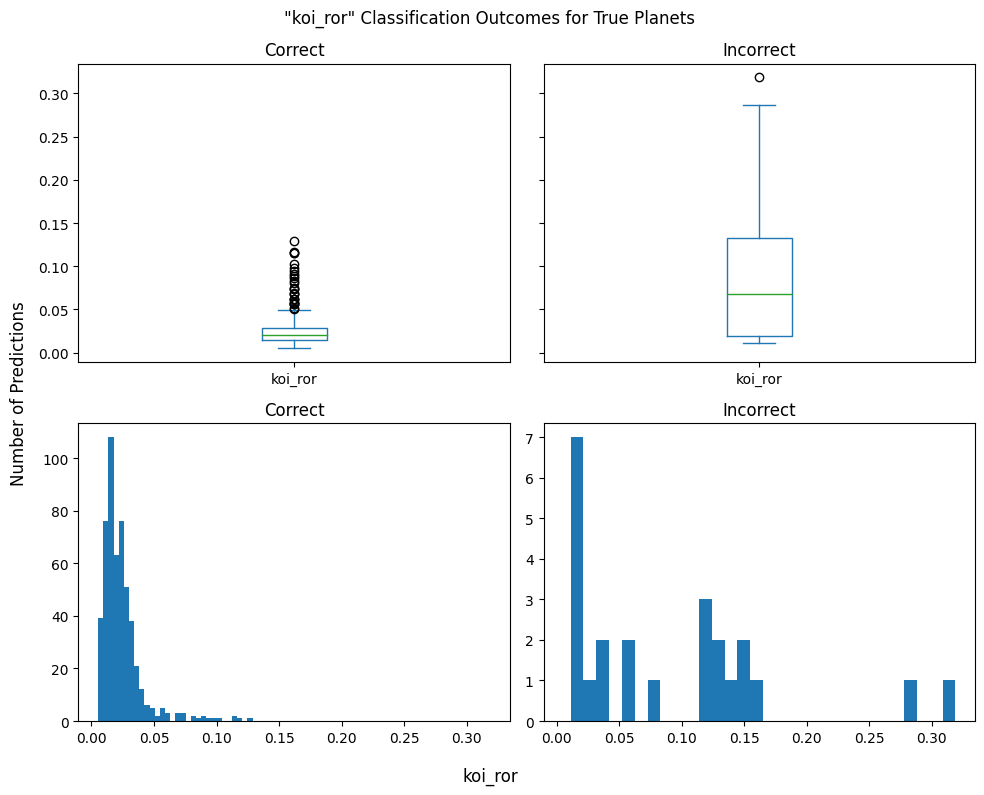

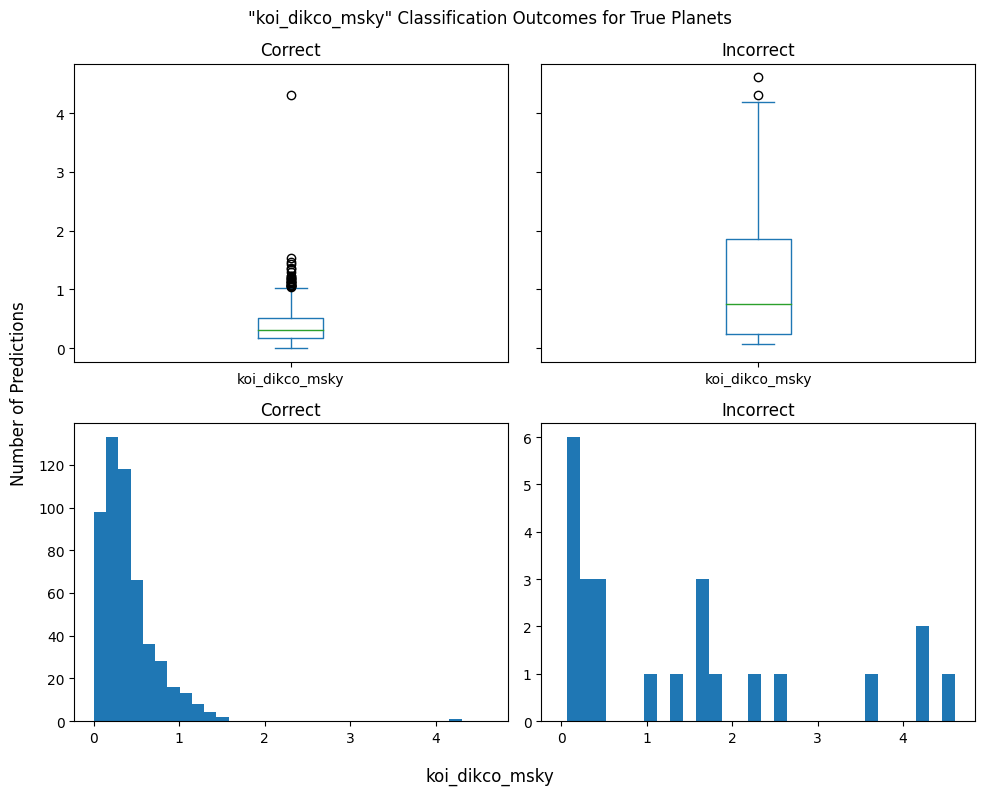

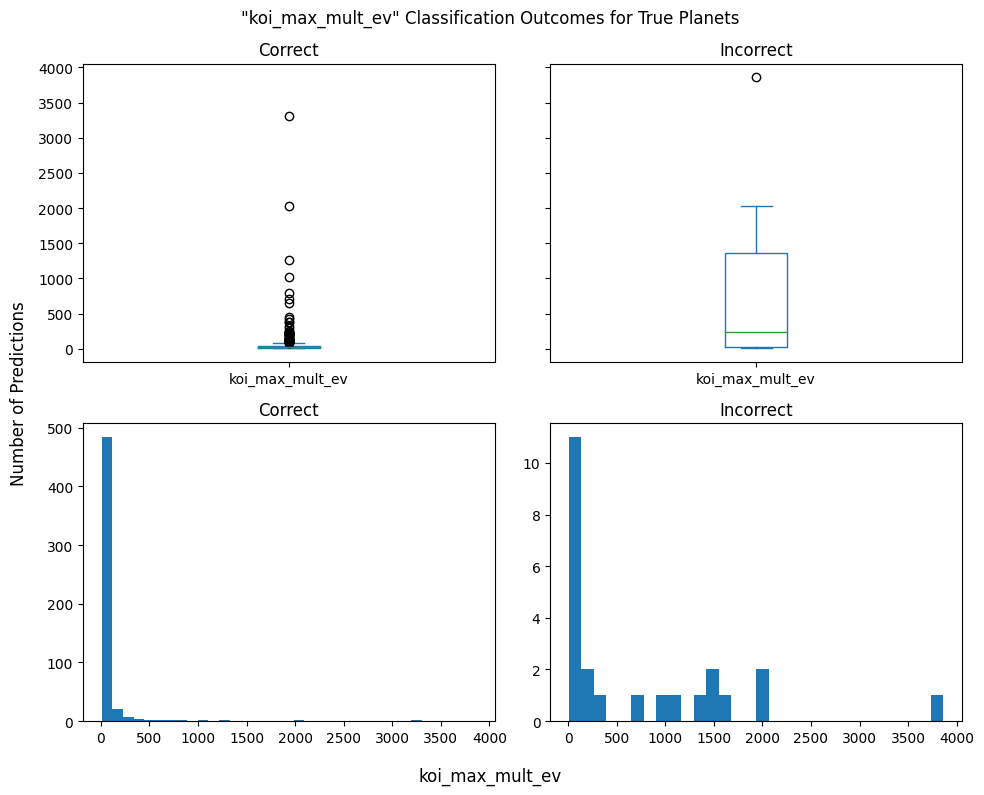

In [33]:
# Columns to explore
cols_to_explore = ['koi_period', 'koi_duration', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']

for class_index in [0, 1]:

    # Getting the data that made correct and incorrect predictions
    is_correct = ((y_test == y_pred) & (y_test == class_index))
    is_wrong = ((y_test != y_pred) & (y_test == class_index))
    correct_names = data_test[is_correct]['kepoi_name'].unique()
    wrong_names = data_test[is_wrong]['kepoi_name'].unique()
    correct_data = raw_KOI[raw_KOI['kepoi_name'].isin(correct_names)]
    wrong_data = raw_KOI[raw_KOI['kepoi_name'].isin(wrong_names)]

    # Plot
    for col in cols_to_explore:

        fig = plt.figure(figsize=(10, 8))

        # Set box plots
        ax1 = fig.add_subplot(2, 2, 1)
        correct_data[col].plot.box()
        ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)
        wrong_data[col].plot.box()
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        ax1.set_title('Correct')
        ax2.set_title('Incorrect')

        # Set histograms
        ax1 = fig.add_subplot(2, 2, 3)
        correct_data[col].plot.hist(bins=30)
        ax2 = fig.add_subplot(2, 2, 4, sharex=ax1)
        wrong_data[col].plot.hist(bins=30)
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        ax1.set_title('Correct')
        ax2.set_title('Incorrect')


        # Adjust labels and titles
        fig.supxlabel(f'{col}')
        fig.supylabel('Number of Predictions')
        if class_index == 1:
            fig.suptitle(f'"{col}" Classification Outcomes for True Planets')
        else:
            fig.suptitle(f'"{col}" Classification Outcomes for False Positives')
        plt.tight_layout()
        plt.show()

## RNN

We will make predictions on test set.

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       748
           1       0.90      0.94      0.92       713

    accuracy                           0.92      1461
   macro avg       0.92      0.92      0.92      1461
weighted avg       0.92      0.92      0.92      1461

Confusion Matrix


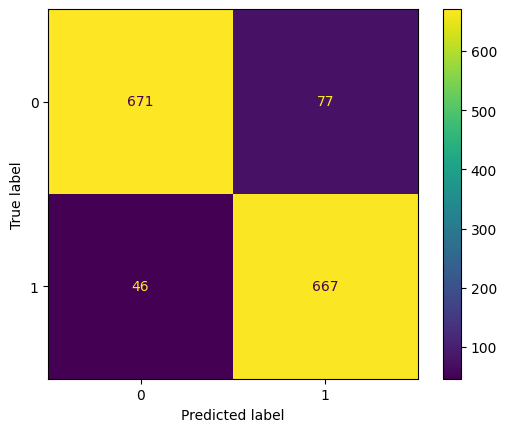

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


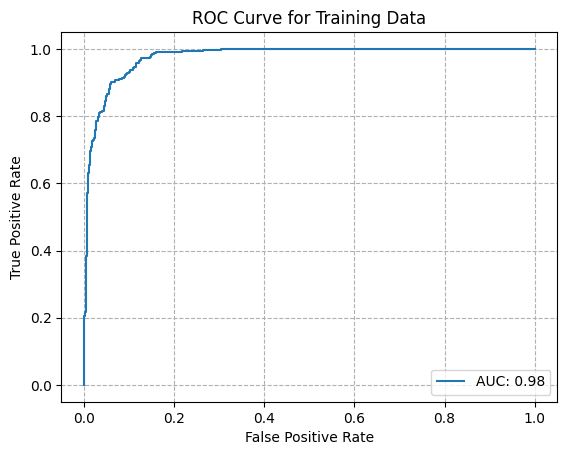

In [34]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load data
raw_KOI = pd.read_csv('KOI_cumulative.csv', comment='#')
data = pd.read_csv('transits.csv')
data = data.merge(raw_KOI.reset_index()[['kepoi_name', 'koi_disposition', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']], on='kepoi_name')

# Filter to only get time, flux, and the 3 contextual features
cols = data.columns
for col in cols:
    if (col.find('TIME') != -1 and col.find('CORR') == -1) or (col.find('PDCSAP_FLUX') != -1 and col.find('ERR') == -1) or (col.find('koi_disposition') != -1) or (col.find('koi_ror') != -1) or (col.find('koi_dikco_msky') != -1) or (col.find('koi_max_mult_ev') != -1) or (col.find('kepoi_name') != -1) or (col.find('kepid') != -1):
        pass
    else:
        data = data.drop(columns=col)

# Filter to not include candidate class
data = data[data['koi_disposition'] != 'CANDIDATE'].dropna()

# Split data into training and testing (80-20)
y = data['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=y)
y_train = data_train['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_train = data_train.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])
y_test = data_test['koi_disposition'].apply(lambda val: 1 if val == 'CONFIRMED' else 0)
X_test = data_test.drop(columns=['koi_disposition', 'kepid', 'kepoi_name'])

# Scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=scaler.get_feature_names_out())
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=scaler.get_feature_names_out())

# Format X_train and y_train into numpy arrays
time_cols = []
flux_cols = []

for col in X_test.columns:
    if (col.find('TIME') != -1):
        time_cols.append(col)
    elif (col.find('PDCSAP_FLUX') != -1):
        flux_cols.append(col)

X_test_time = X_test[time_cols].to_numpy()
X_test_flux = X_test[flux_cols].to_numpy()
X_test_timesteps = np.stack((X_test_time, X_test_flux), axis=-1)
X_test_context = X_test[['koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']].to_numpy()
y_test = y_test.to_numpy()

# Show classification report
model = joblib.load('Models/RNN.pkl')
y_pred = model.predict([X_test_timesteps, X_test_context])
y_pred = (y_pred > 0.5).astype(int)
print('Classification Report')
print(classification_report(y_test, y_pred))

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion)
print('Confusion Matrix')
disp.plot()
plt.show()

# Plot ROC curve
y_probs = model.predict([X_test_timesteps, X_test_context])
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training Data')
plt.grid(linestyle='--')
plt.legend()
plt.show()

Now we will explore distributions.

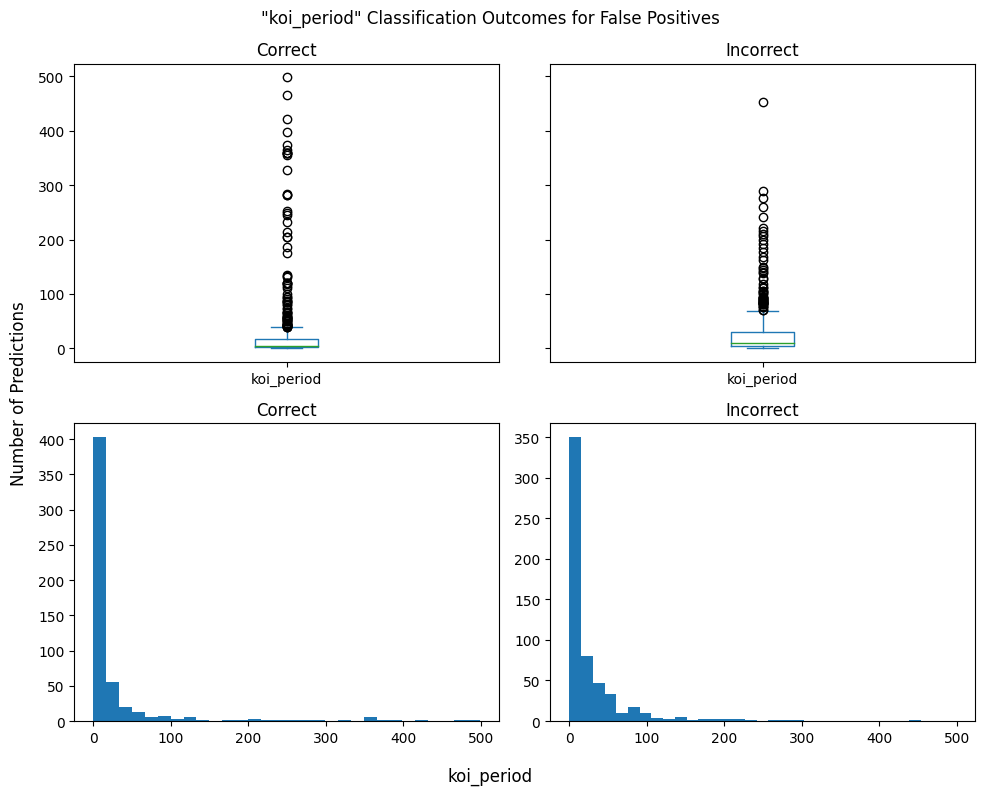

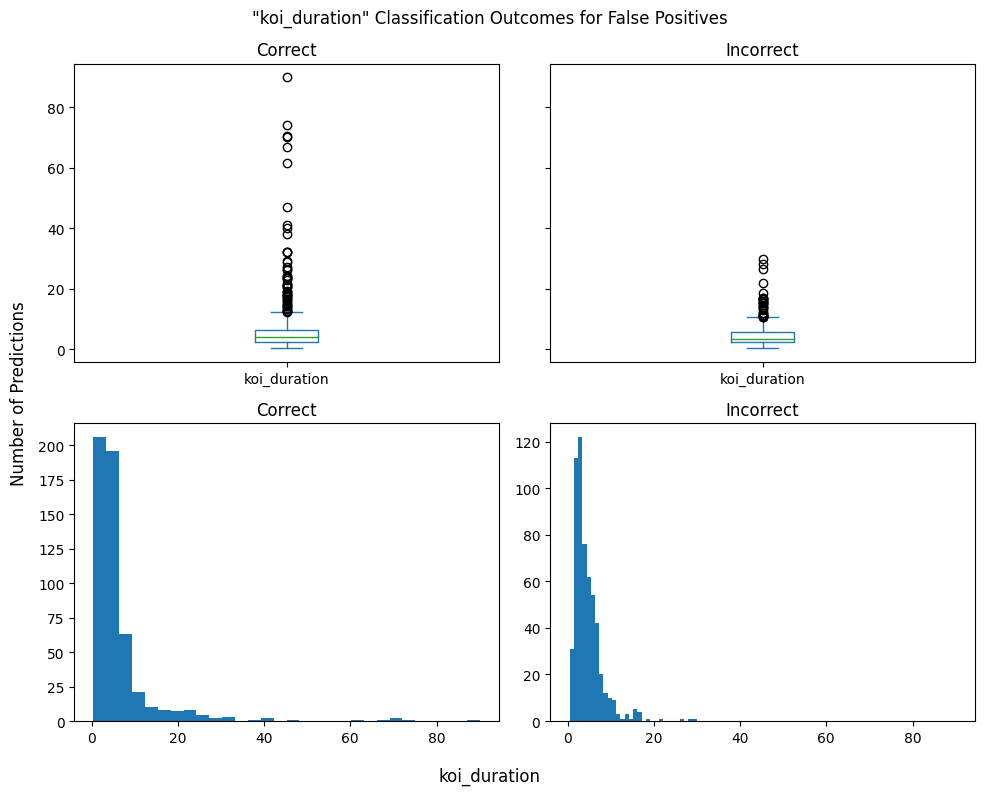

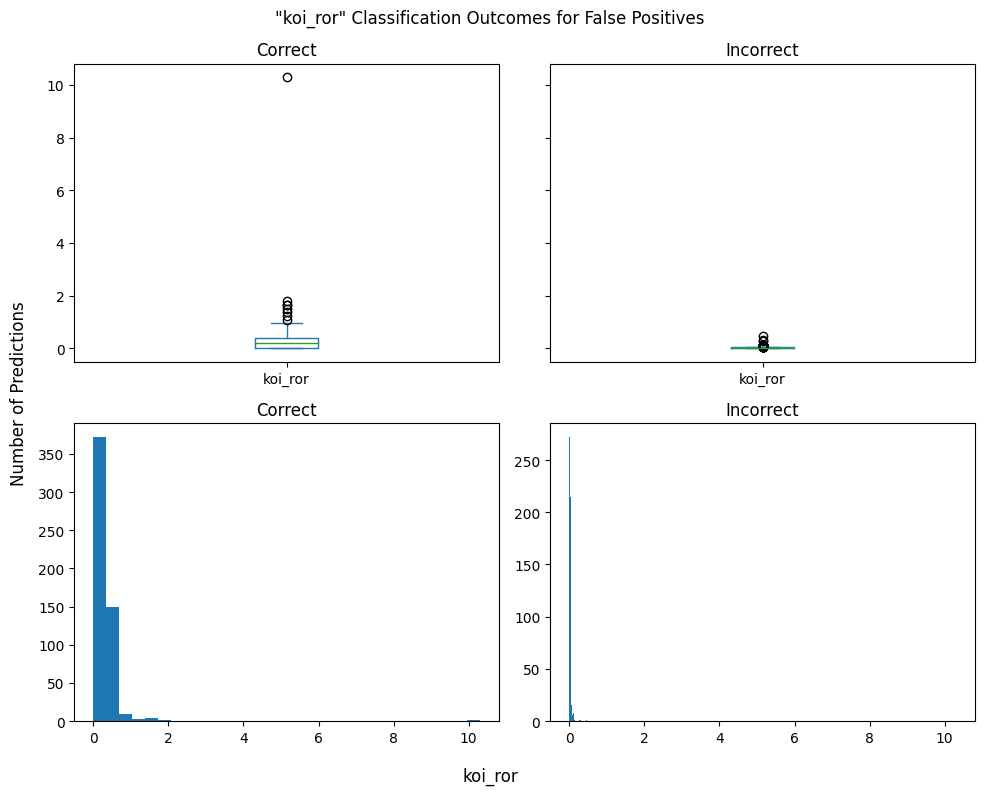

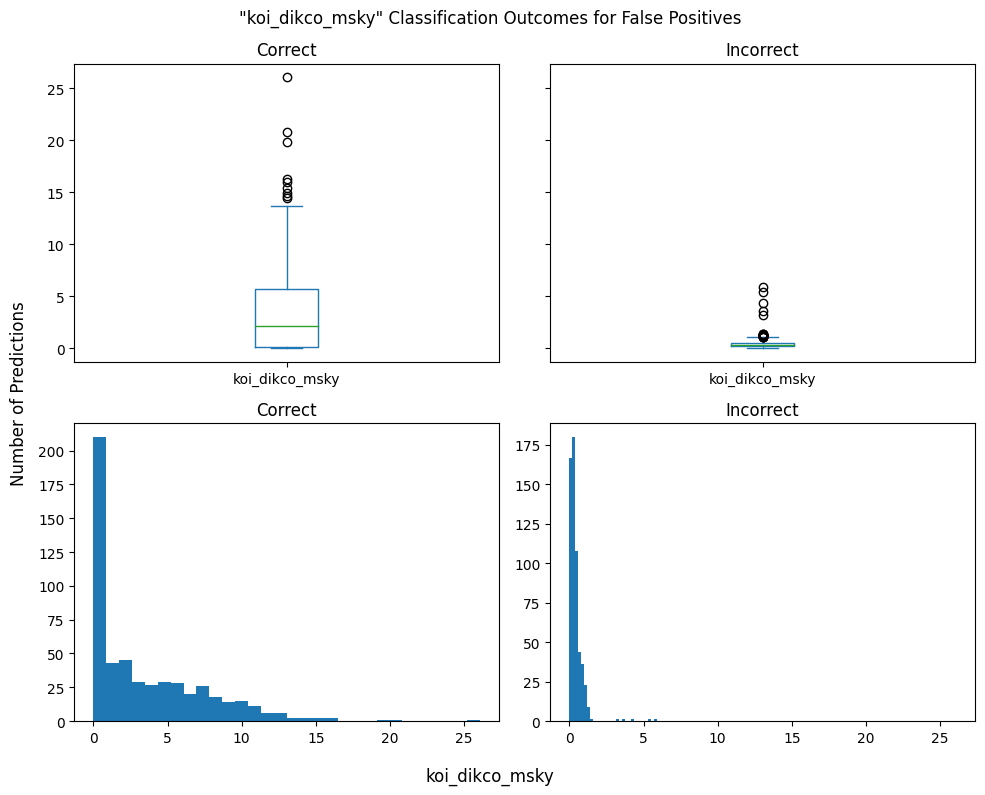

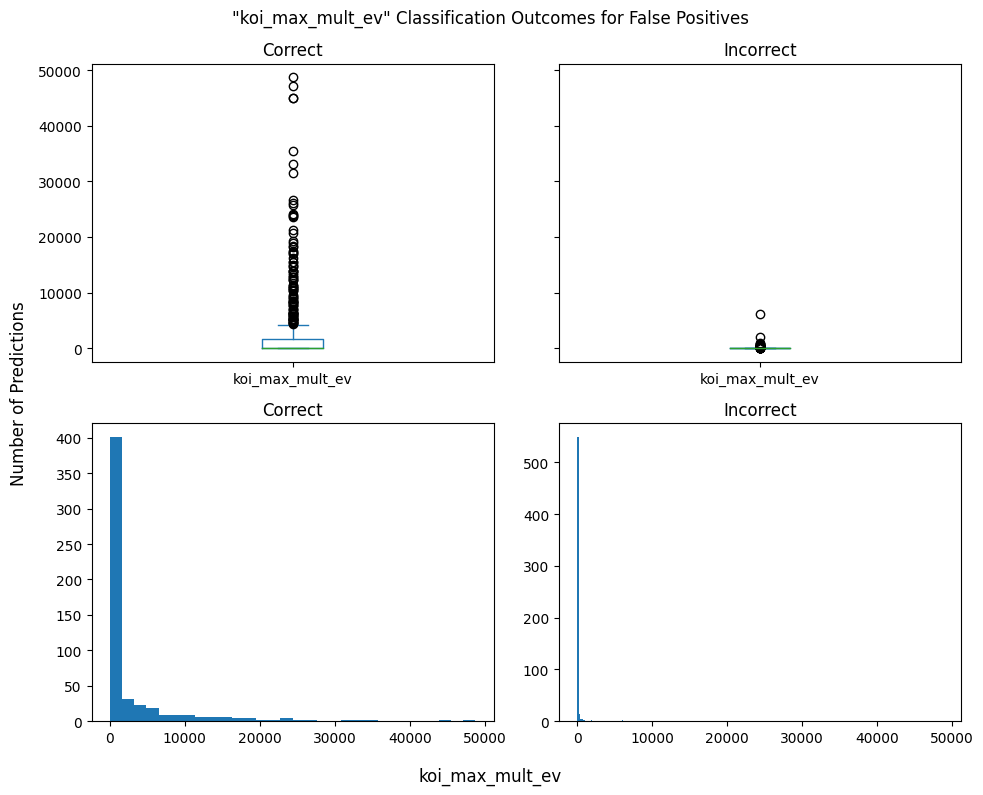

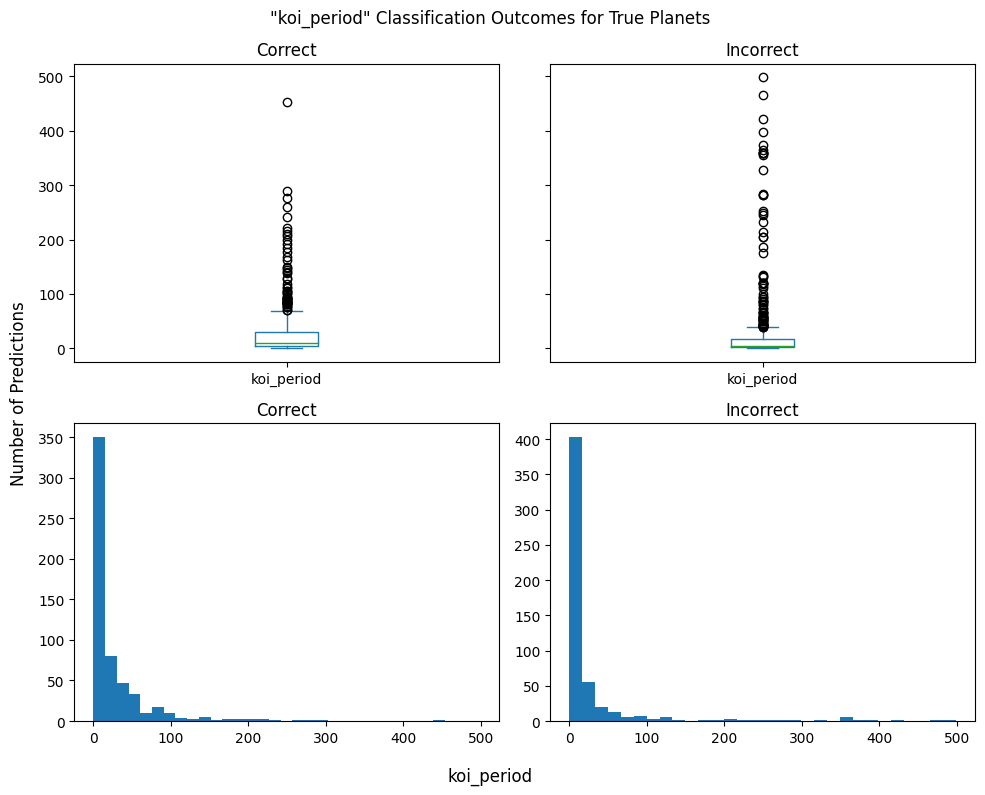

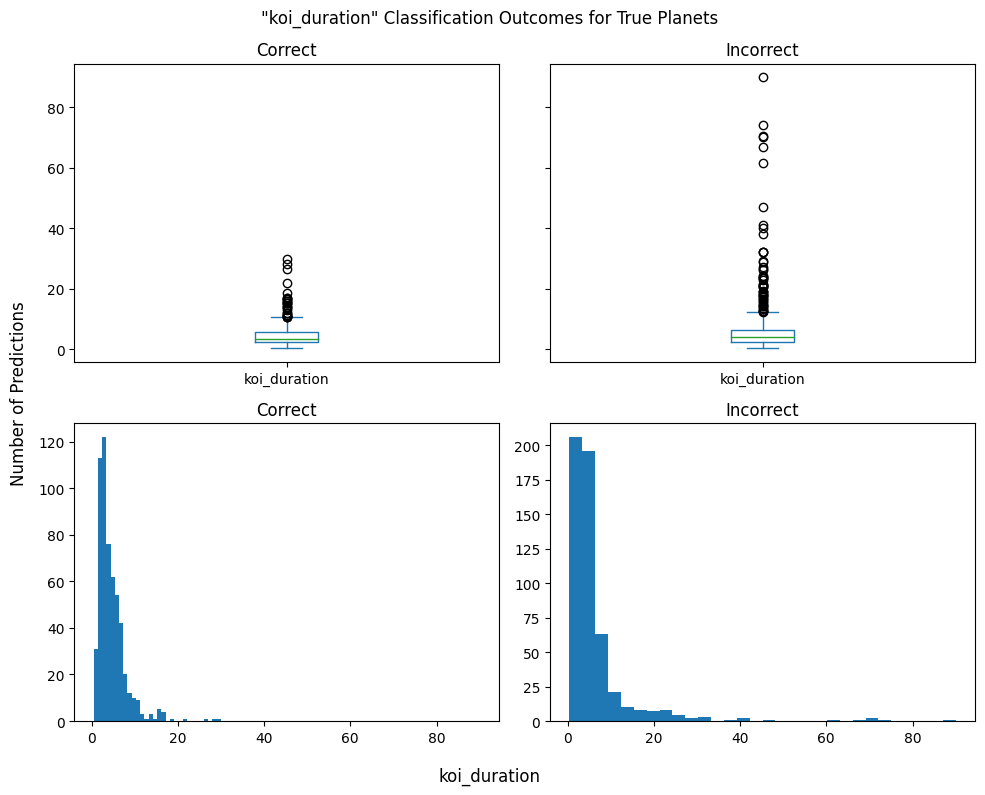

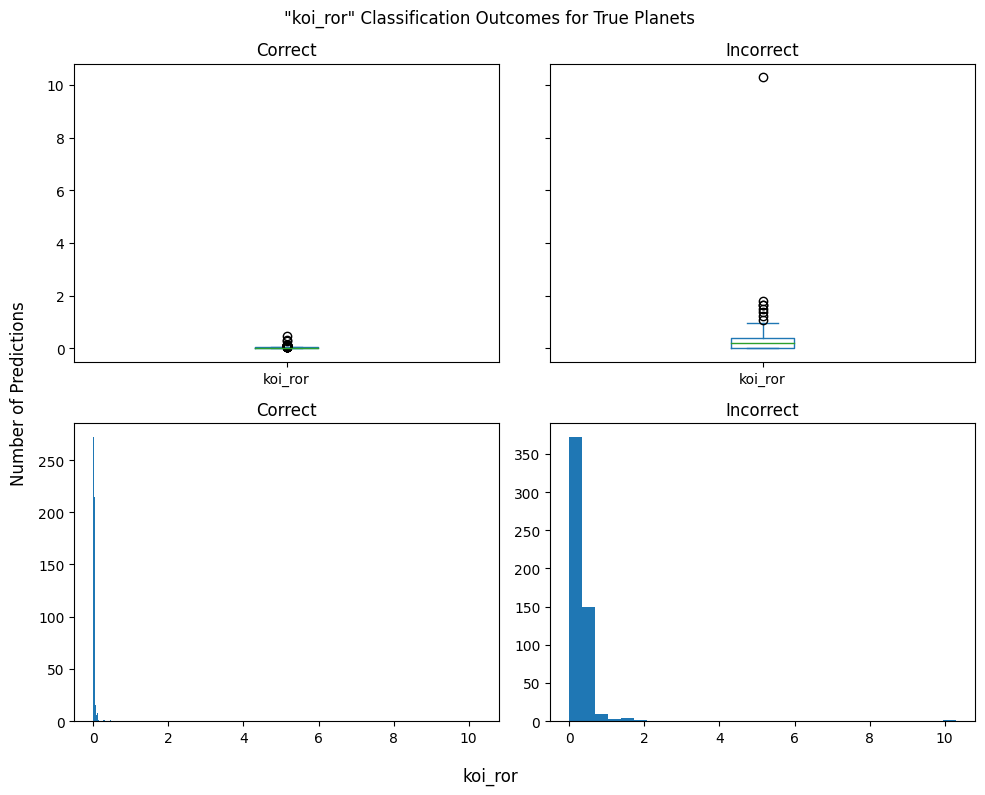

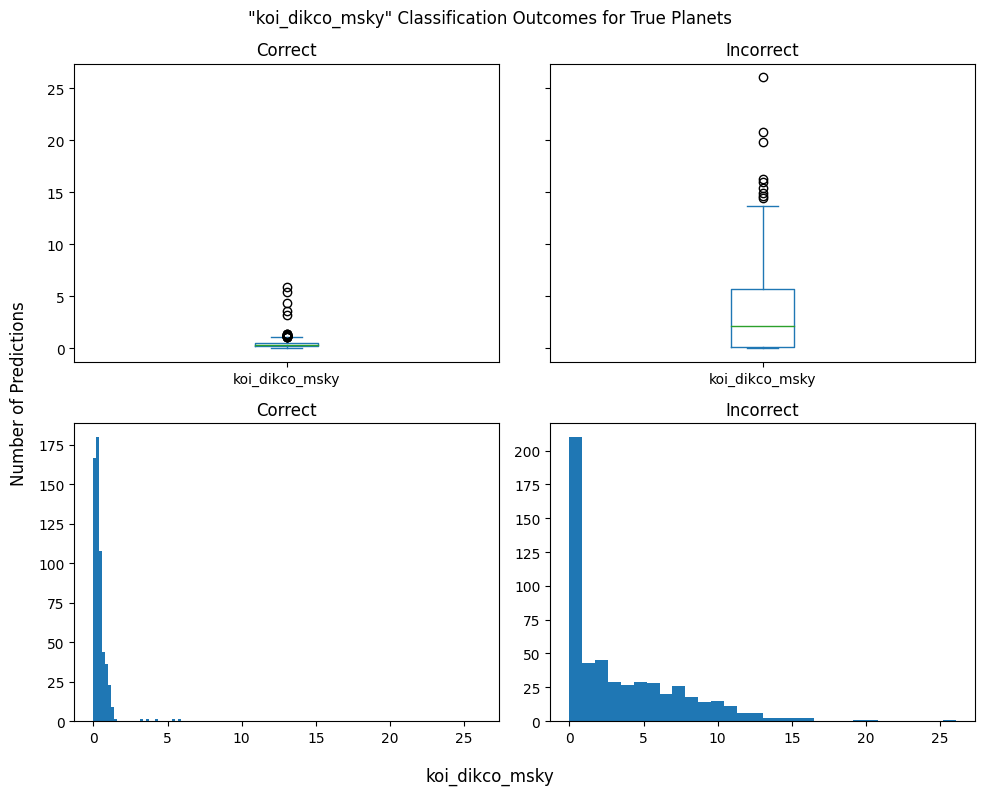

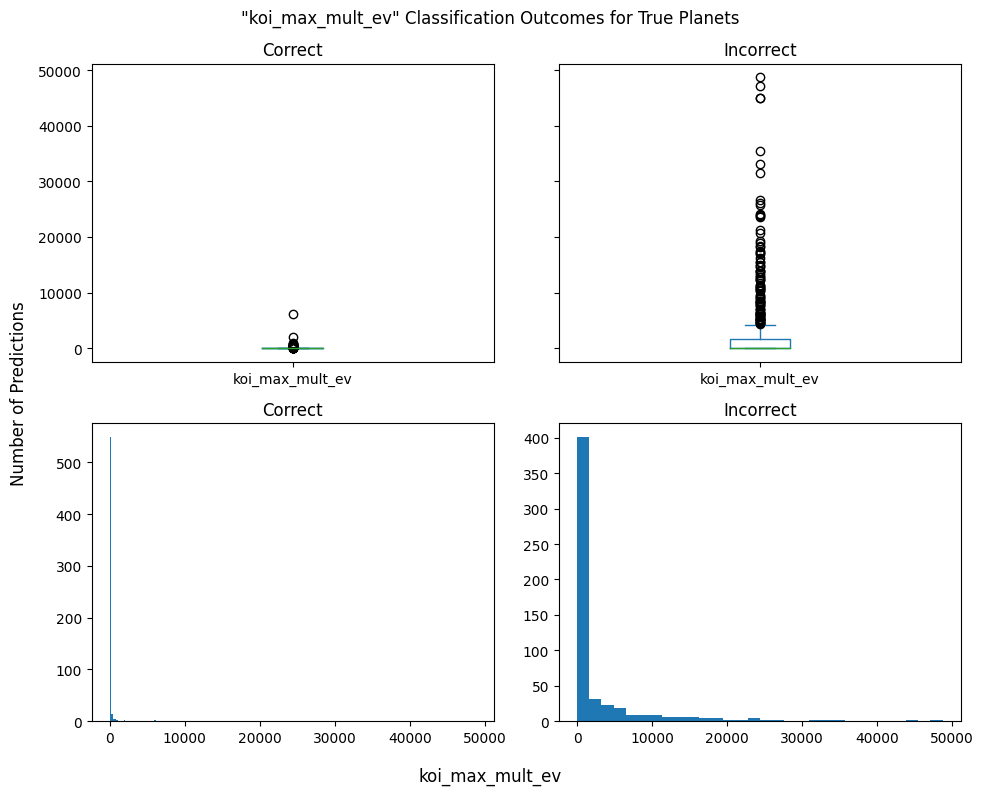

In [35]:
# Columns to explore
cols_to_explore = ['koi_period', 'koi_duration', 'koi_ror', 'koi_dikco_msky', 'koi_max_mult_ev']

for class_index in [0, 1]:

    # Getting the data that made correct and incorrect predictions
    is_correct = ((y_test == y_pred) & (y_test == class_index))
    is_wrong = ((y_test != y_pred) & (y_test == class_index))
    correct_names = data_test[is_correct]['kepoi_name'].unique()
    wrong_names = data_test[is_wrong]['kepoi_name'].unique()
    correct_data = raw_KOI[raw_KOI['kepoi_name'].isin(correct_names)]
    wrong_data = raw_KOI[raw_KOI['kepoi_name'].isin(wrong_names)]

    # Plot
    for col in cols_to_explore:

        fig = plt.figure(figsize=(10, 8))

        # Set box plots
        ax1 = fig.add_subplot(2, 2, 1)
        correct_data[col].plot.box()
        ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)
        wrong_data[col].plot.box()
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        ax1.set_title('Correct')
        ax2.set_title('Incorrect')

        # Set histograms
        ax1 = fig.add_subplot(2, 2, 3)
        correct_data[col].plot.hist(bins=30)
        ax2 = fig.add_subplot(2, 2, 4, sharex=ax1)
        wrong_data[col].plot.hist(bins=30)
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax2.set_xlabel('')
        ax2.set_ylabel('')
        ax1.set_title('Correct')
        ax2.set_title('Incorrect')


        # Adjust labels and titles
        fig.supxlabel(f'{col}')
        fig.supylabel('Number of Predictions')
        if class_index == 1:
            fig.suptitle(f'"{col}" Classification Outcomes for True Planets')
        else:
            fig.suptitle(f'"{col}" Classification Outcomes for False Positives')
        plt.tight_layout()
        plt.show()